In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as random
import jax.scipy as jsp
from minigp.gp import *
from minigp.kernel import DeepKernelParameters, DeepKernel
from minigp.utils import *

In [2]:
def warp(x: jnp.ndarray) -> jnp.ndarray:
    """Warping function that maps [0, 24pi] to [0, 12pi], with non-linear squeezing."""
    # Define boundaries
    segment1 = 2 * jnp.pi
    segment2 = 10 * jnp.pi
    max_x = 12 * jnp.pi

    # Define corresponding warped boundaries
    warped_segment1 = 16 * jnp.pi
    warped_segment2 = 18 * jnp.pi
    max_warped = 34 * jnp.pi

    # Apply piecewise transformation
    warped_x = jnp.where(x <= segment1,
                         x * (warped_segment1 / segment1),  # Squeeze the first segment
                         jnp.where(x <= segment2,
                                   (x - segment1) * ((warped_segment2 - warped_segment1) / (segment2 - segment1)) + warped_segment1,  # Middle segment mostly unchanged
                                   (x - segment2) * ((max_warped - warped_segment2) / (max_x - segment2)) + warped_segment2  # Squeeze the last segment
                         ))
    return warped_x

def warped_sine(x: jnp.ndarray) -> jnp.ndarray:
    """Compute sine of the warped input."""
    warped_x = warp(x)
    return jnp.sin(warped_x)


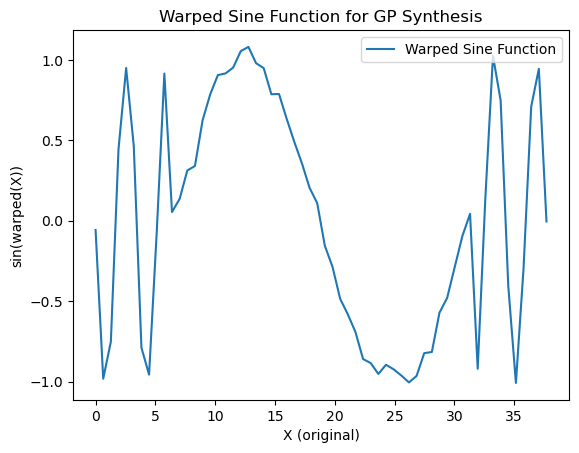

In [3]:
X_train = jnp.linspace(0, 12 * jnp.pi, 60).reshape(-1, 1)
y_train = warped_sine(X_train.flatten()) + 0.05 * random.normal(jax.random.PRNGKey(0), (60,))

X_np = np.array(X_train)
y_np = np.array(y_train)

# Plot the warped sine function
plt.plot(X_np, y_np, label="Warped Sine Function")
plt.title("Warped Sine Function for GP Synthesis")
plt.xlabel("X (original)")
plt.ylabel("sin(warped(X))")
plt.legend()
plt.show()

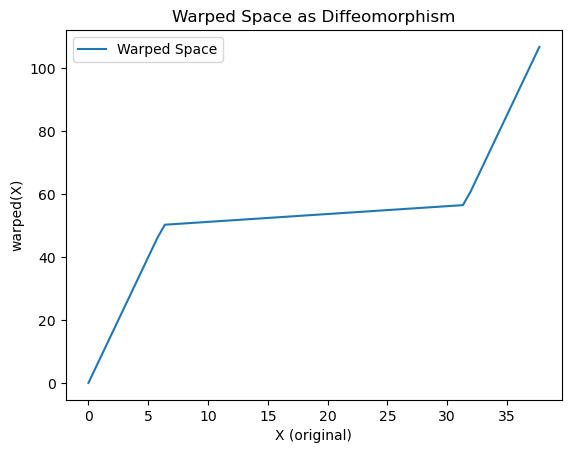

In [4]:
plt.plot(X_np, np.array(warp(X_train)), label="Warped Space")
plt.title("Warped Space as Diffeomorphism")
plt.xlabel("X (original)")
plt.ylabel("warped(X)")
plt.legend()
plt.show()

In [5]:
block = [1,15,15]
layer_dims = block * 10 + [1]

key = jax.random.PRNGKey(0)

net = ResNetNN(layer_dims, key)
kernel = DeepKernel(net_fn=net, layer_dims=layer_dims)
kernel_params = kernel.init_params(key)

gp = GaussianProcess()
state, gp_params = gp.init_state_with_params(kernel, kernel_params, X_train, y_train)

In [6]:
optimized_kernel_params, optimized_gp_params = optimize_mle_nn(gp, state, kernel_params, gp_params, num_iters= 300, learning_rate = 0.01)
state, gp_params = gp.fit(state, optimized_kernel_params, optimized_gp_params)

Iteration 50, Loss: 55.7181
Iteration 100, Loss: 54.8342
Iteration 150, Loss: 53.3541
Iteration 200, Loss: 53.6999
Iteration 250, Loss: 52.7030
Iteration 300, Loss: 57.5430


[0.962589   0.962589   0.962589   0.962589   0.962589   0.962589
 0.962589   0.962589   0.962589   0.962589   0.962589   0.962589
 0.96258897 0.96258897 0.96258885 0.96258867 0.9625883  0.9625878
 0.96258676 0.962585   0.9625818  0.96257627 0.96256673 0.9625513
 0.96252644 0.96248645 0.96242106 0.9623167  0.9621563  0.96191025
 0.9615371  0.9609824  0.9601668  0.9590145  0.9574415  0.95528084
 0.95241255 0.94857204 0.9428015  0.9289396  0.90905714 0.88295215
 0.84785134 0.79315597 0.6684066  0.561275   0.42007473 0.1787618
 0.02321134 0.15168542 0.20615634 0.17717731 0.0810238  0.00258374
 0.04386454 0.06210968 0.05648783 0.03305109 0.00261812 0.02538358
 0.04057658 0.04008221 0.02559404 0.0038292  0.01658001 0.02942376
 0.03144205 0.0222637  0.00532652 0.0144105  0.02923781 0.03425285
 0.02699935 0.00864892 0.02009234 0.05212388 0.06462491 0.04859073
 0.0172875  0.02139402 0.05532466 0.0738157  0.06674021 0.02916638
 0.02538358 0.07523969 0.10020121 0.0878428  0.04110128 0.02328825
 0

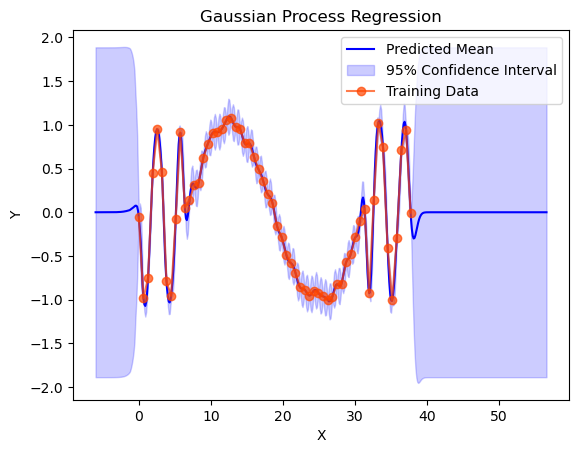

In [7]:
X_test = jnp.linspace(-6, 18 * jnp.pi, 500).reshape(-1, 1)
y_true = warped_sine(X_test.flatten())
mu_s, cov_s = gp.predict(state, optimized_kernel_params, optimized_gp_params, X_test)
std_s = jnp.sqrt(cov_s)
print(std_s)
plot_process(X_train, y_train, X_test, mu_s, std_s)

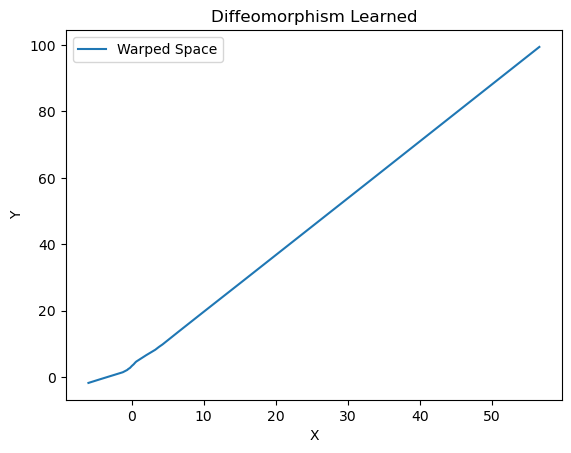

In [8]:
plot_diffeomorphism_1D(X_test, kernel, optimized_kernel_params)

In [9]:
print(optimized_kernel_params.log_alpha)
print(gp_params.noise)

-0.07625851
-13.750472
